In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.Pipelines.skypy_pipeline import SkyPyPipeline
from slsim.Pipelines.sl_hammocks_pipeline import SLHammocksPipeline
from slsim.Lenses.lens_pop import LensPop
import slsim.Deflectors as deflectors
import slsim.Sources as sources
import corner

# Galaxy-galaxy lens population with SLHammock deflectors

This notebook walks through the basics of simulating a galaxy-galaxy strong lensing population using SLHammock deflectors.

The notebook goes in three steps:

1. The populations of lenses and sources is produced
2. The full population is generated in catalogue form
3. the full population is represented in a corner plot


In [3]:
# define a cosmology
cosmology2 = FlatLambdaCDM(H0=70, Om0=0.3)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)

# define a sky area
sky_area = Quantity(value=5, unit="deg2")
sky_area_deflector = Quantity(value=10, unit="deg2")
sky_area_full = Quantity(value=10, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 28, "z_min": 0.01, "z_max": 2}
kwargs_source_cut = {"band": "g", "band_max": 28, "z_min": 0.1, "z_max": 5.0}

In [4]:
# Generate galaxy population using skypy pipeline. Blue galaxies from this simulation
# will be used as source population.
galaxy_simulation_pipeline = SkyPyPipeline(
    skypy_config=None, sky_area=sky_area, filters=None, cosmo=cosmo
)

In [5]:
# Generate halo galaxy population using SLHammock pipeline. Halo galaxies from this simulation
# will be used as deflector population. One can specify minimum and maximum values for
# redshift and log10 of halo mass.
halo_galaxy_pipeline = SLHammocksPipeline(
    slhammocks_config=None,
    sky_area=sky_area_deflector,
    cosmo=cosmo,
    z_min=0.01,
    z_max=2,
    loghm_min=13,
    loghm_max=16,
)

In [6]:
# Initiate deflector population class.
lens_galaxies = deflectors.CompoundLensHalosGalaxies(
    halo_galaxy_list=halo_galaxy_pipeline.halo_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=sky_area,
)

In [7]:
# Initiate source population class.
source_galaxies = sources.Galaxies(
    galaxy_list=galaxy_simulation_pipeline.blue_galaxies,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    catalog_type="skypy",
)

In [8]:
# make galaxy-galaxy population class using LensPop
gg_lens_pop = LensPop(
    deflector_population=lens_galaxies,
    source_population=source_galaxies,
    cosmo=cosmo,
    sky_area=sky_area_full,
)

## Generate the full population
We are using the instance of the LensPop() class to draw the full population within specified cuts in a Monte Carlo process.

In [9]:
kwargs_lens_cut = {"min_image_separation": 0.8, "max_image_separation": 10}
lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cut)

## Represent key quantities of full population in corner plots
We calculate few key quantities of the lenses. The full population is represented each with a Lens() class

object that allows to compute and return these (and more) quantities.

In [10]:
print("Number of lenses:", len(lens_population))

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\log(h_{m})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    halo_mass = gg_lens.deflector.halo_properties[0]
    theta_e = gg_lens.einstein_radius[0]
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift_list[0]
    source_mag = gg_lens.extended_source_magnitude(band="i", lensed=True)[0]
    deflector_mag = gg_lens.deflector_magnitude(band="i")
    lens_samples.append(
        [
            vel_disp,
            np.log10(m_star),
            np.log10(halo_mass),
            theta_e,
            zl,
            zs,
            source_mag,
            deflector_mag,
        ]
    )

Number of lenses: 739


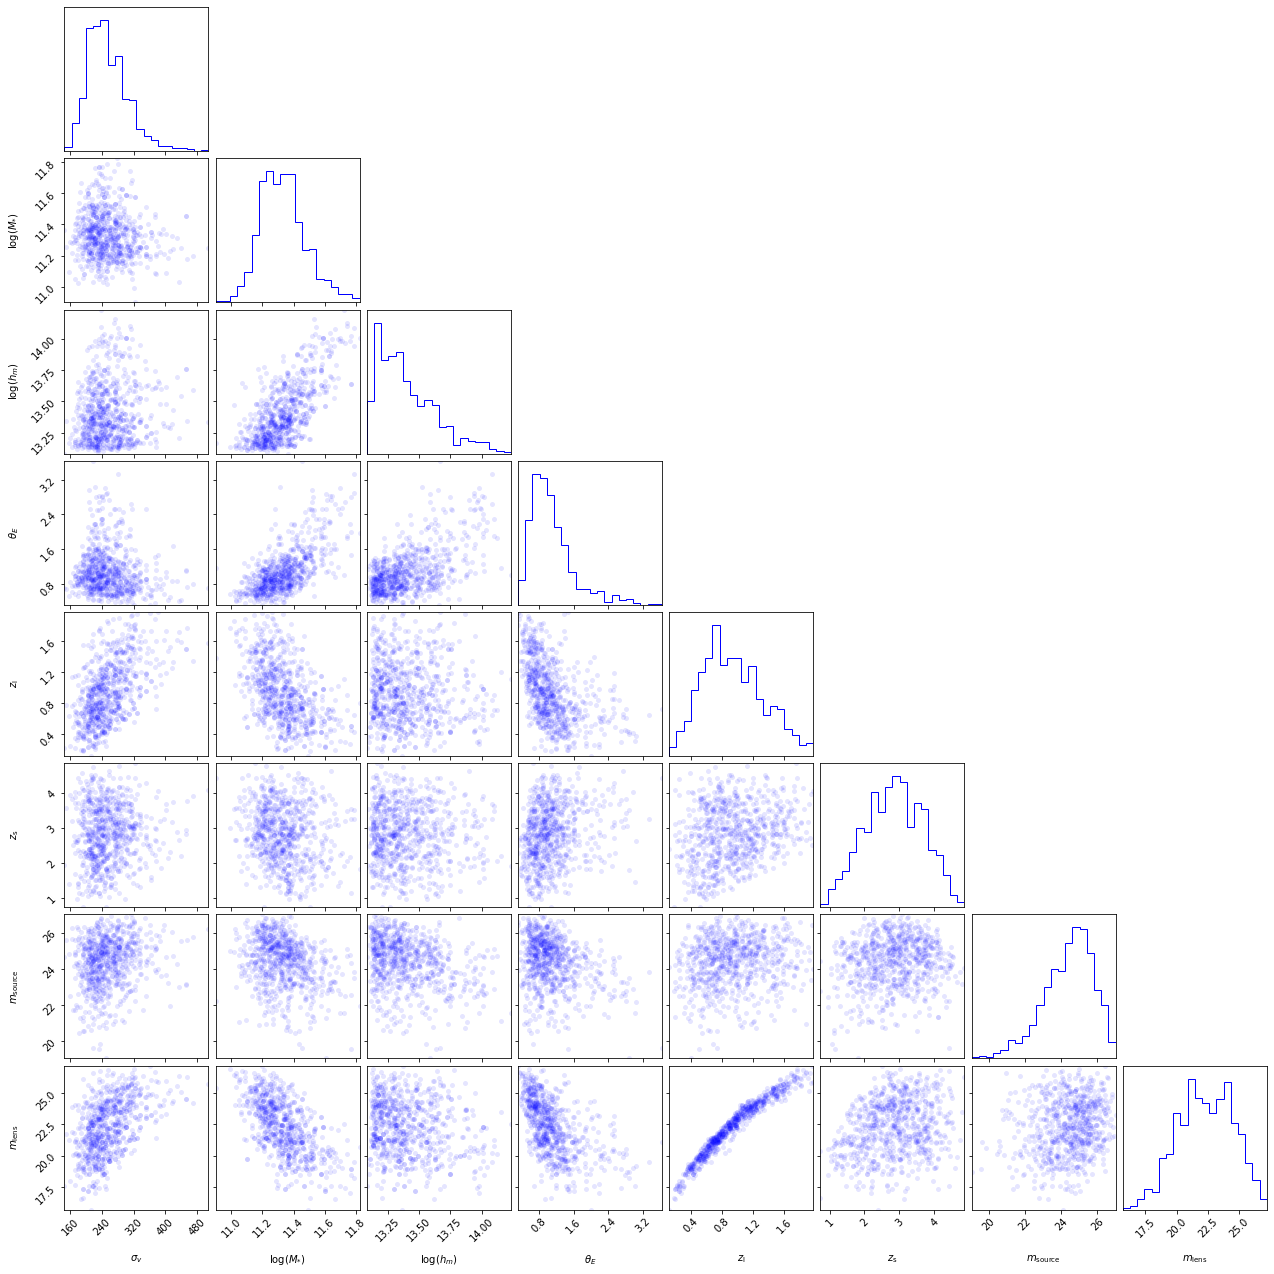

In [ ]:
hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()